# 🏠 Analyse de Régression des Prix Immobiliers
## Prédiction des Prix des Maisons d'Ames, Iowa

Ce notebook présente une analyse complète de régression avec :
- Exploration et préparation des données
- Modélisation : **Linéaire, Lasso, Ridge, ElasticNet, Decision Tree, Random Forest, XGBoost, SVR**
- Sélection de variables (RFE et Backward Elimination)
- Comparaison comparative complète des performances

## 1. Configuration et Imports

In [1]:
# Imports essentiels
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import skew, kurtosis
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')

# ML — Modèles linéaires
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.feature_selection import RFE

# ML — Nouveaux modèles
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor

# Config graphiques
plt.rcParams['figure.figsize'] = (12, 8)
sns.set_style('whitegrid')
sns.set_palette('husl')

print('✅ Configuration terminée')

✅ Configuration terminée


## 2. Chargement et Préparation des Données

In [2]:
# Chargement
df = pd.read_csv('train.csv')
print(f"Dataset shape: {df.shape}")
print(f"\nPremières lignes:")
print(df.head())

Dataset shape: (1460, 81)

Premières lignes:
   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  Sal

In [3]:
# Identification des types de variables
numeric_features = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = df.select_dtypes(include=['object']).columns.tolist()

# Retirer Id et SalePrice
if 'Id' in numeric_features:
    numeric_features.remove('Id')
if 'SalePrice' in numeric_features:
    numeric_features.remove('SalePrice')

print(f"Variables numériques: {len(numeric_features)}")
print(f"Variables catégorielles: {len(categorical_features)}")

# Traitement des valeurs manquantes
df_clean = df.copy()
num_imputer = SimpleImputer(strategy='median')
cat_imputer = SimpleImputer(strategy='most_frequent')

df_clean[numeric_features] = num_imputer.fit_transform(df_clean[numeric_features])
df_clean[categorical_features] = cat_imputer.fit_transform(df_clean[categorical_features])

# Encodage
df_encoded = pd.get_dummies(df_clean, columns=categorical_features, drop_first=True)

# Transformation log de la cible
df_encoded['SalePrice_log'] = np.log1p(df_encoded['SalePrice'])

print(f"\n✅ Après encodage: {df_encoded.shape[1]} variables")
print(f"Skewness SalePrice original: {skew(df_encoded['SalePrice']):.4f}")
print(f"Skewness SalePrice log: {skew(df_encoded['SalePrice_log']):.4f}")

Variables numériques: 36
Variables catégorielles: 43

✅ Après encodage: 247 variables
Skewness SalePrice original: 1.8809
Skewness SalePrice log: 0.1212


In [4]:
# Suppression des outliers
print(f"Avant suppression outliers: {len(df_encoded)}")
df_no_outliers = df_encoded[
    (df_encoded['GrLivArea'] < 4000) | (df_encoded['SalePrice'] > 300000)
]
print(f"Après suppression outliers: {len(df_no_outliers)}")

# Préparation X et y
X = df_no_outliers.drop(['Id', 'SalePrice', 'SalePrice_log'], axis=1, errors='ignore')
y = df_no_outliers['SalePrice_log']

# Normalisation
scaler = StandardScaler()
X_scaled = pd.DataFrame(
    scaler.fit_transform(X),
    columns=X.columns,
    index=X.index
)

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

print(f"\n✅ Préparation terminée")
print(f"X_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")

Avant suppression outliers: 1460
Après suppression outliers: 1458

✅ Préparation terminée
X_train: (1166, 244)
X_test: (292, 244)


## 3. Fonction d'Évaluation

In [5]:
def evaluate_model(name, model, X_train, X_test, y_train, y_test):
    """
    Évalue un modèle et retourne les métriques
    """
    # Entraînement
    model.fit(X_train, y_train)
    
    # Prédictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Métriques
    results = {
        'Model': name,
        'Train_RMSE': np.sqrt(mean_squared_error(y_train, y_train_pred)),
        'Test_RMSE': np.sqrt(mean_squared_error(y_test, y_test_pred)),
        'Train_MAE': mean_absolute_error(y_train, y_train_pred),
        'Test_MAE': mean_absolute_error(y_test, y_test_pred),
        'Train_R2': r2_score(y_train, y_train_pred),
        'Test_R2': r2_score(y_test, y_test_pred),
        'CV_RMSE': np.sqrt(-cross_val_score(
            model, X_train, y_train, 
            scoring='neg_mean_squared_error', cv=5
        ).mean())
    }
    
    return results

print('✅ Fonction d\'évaluation définie')

✅ Fonction d'évaluation définie


## 4. Entraînement des Modèles (Toutes Variables)

In [6]:
print("="*70)
print("ENTRAÎNEMENT DES MODÈLES - TOUTES VARIABLES")
print("="*70)

results = {}

# Linear Regression
print("\n1. Linear Regression")
lr = LinearRegression()
results['Linear'] = evaluate_model('Linear', lr, X_train, X_test, y_train, y_test)
print(f"   Test R²: {results['Linear']['Test_R2']:.4f}")

# Lasso
print("\n2. Lasso")
lasso = Lasso(alpha=0.001, max_iter=10000, random_state=42)
results['Lasso'] = evaluate_model('Lasso', lasso, X_train, X_test, y_train, y_test)
print(f"   Test R²: {results['Lasso']['Test_R2']:.4f}")

# Ridge
print("\n3. Ridge")
ridge = Ridge(alpha=10, random_state=42)
results['Ridge'] = evaluate_model('Ridge', ridge, X_train, X_test, y_train, y_test)
print(f"   Test R²: {results['Ridge']['Test_R2']:.4f}")

# ElasticNet
print("\n4. ElasticNet")
elastic = ElasticNet(alpha=0.001, l1_ratio=0.5, max_iter=10000, random_state=42)
results['ElasticNet'] = evaluate_model('ElasticNet', elastic, X_train, X_test, y_train, y_test)
print(f"   Test R²: {results['ElasticNet']['Test_R2']:.4f}")

print("\n✅ Entraînement terminé")

# Tableau comparatif
df_results = pd.DataFrame(results).T
print("\n" + "="*70)
print("RÉSULTATS - TOUTES VARIABLES")
print("="*70)
print(df_results.to_string())

ENTRAÎNEMENT DES MODÈLES - TOUTES VARIABLES

1. Linear Regression
   Test R²: 0.8923

2. Lasso
   Test R²: 0.9014

3. Ridge
   Test R²: 0.8976

4. ElasticNet
   Test R²: 0.9028

✅ Entraînement terminé

RÉSULTATS - TOUTES VARIABLES
                 Model Train_RMSE Test_RMSE Train_MAE  Test_MAE  Train_R2   Test_R2   CV_RMSE
Linear          Linear   0.086707  0.134772  0.060658  0.091705  0.952244  0.892253  0.133068
Lasso            Lasso   0.091608   0.12891   0.06468  0.086413  0.946692  0.901423  0.120003
Ridge            Ridge   0.087839  0.131407  0.061643  0.089961  0.950988  0.897567  0.127819
ElasticNet  ElasticNet   0.089188  0.128037  0.063095   0.08728  0.949472  0.902753  0.122413


## 5. Sélection de Variables - RFE

In [7]:
print("="*70)
print("SÉLECTION DE VARIABLES PAR RFE")
print("="*70)

# RFE avec 50 variables
n_features = 50
rfe = RFE(estimator=LinearRegression(), n_features_to_select=n_features)
rfe.fit(X_train, y_train)

selected_features_rfe = X_train.columns[rfe.support_].tolist()

print(f"\nVariables sélectionnées: {len(selected_features_rfe)}/{X_train.shape[1]}")
print(f"Réduction: {(1 - len(selected_features_rfe)/X_train.shape[1])*100:.1f}%")

# Datasets avec variables RFE
X_train_rfe = X_train[selected_features_rfe]
X_test_rfe = X_test[selected_features_rfe]

print("\n✅ Sélection RFE terminée")

SÉLECTION DE VARIABLES PAR RFE

Variables sélectionnées: 50/244
Réduction: 79.5%

✅ Sélection RFE terminée


## 6. Sélection de Variables - Backward Elimination

In [8]:
print("="*70)
print("SÉLECTION DE VARIABLES PAR BACKWARD ELIMINATION")
print("="*70)

def backward_elimination(X, y, significance_level=0.05):
    """
    Effectue une élimination backward basée sur les p-values
    """
    features = list(X.columns)
    removed_features = []
    
    print(f"\nDébut: {len(features)} variables")
    print(f"Seuil: {significance_level}")
    
    iteration = 0
    while True:
        iteration += 1
        
        # Modèle OLS
        X_with_const = sm.add_constant(X[features]).astype(float)
        model = sm.OLS(y.astype(float), X_with_const).fit()
        
        # Trouver max p-value
        p_values = model.pvalues.iloc[1:]  # Sans constante
        max_p_value = p_values.max()
        
        if max_p_value > significance_level:
            excluded_feature = p_values.idxmax()
            features.remove(excluded_feature)
            removed_features.append((excluded_feature, max_p_value))
            
            if iteration <= 10 or iteration % 10 == 0:
                print(f"   Iter {iteration:3d}: Retrait '{excluded_feature}' (p={max_p_value:.4f})")
        else:
            break
    
    print(f"\nTerminé après {iteration} itérations")
    print(f"Variables conservées: {len(features)}")
    
    return features, removed_features

# Appliquer BE
selected_features_be, removed_features_be = backward_elimination(
    X_train, y_train, significance_level=0.05
)

print(f"\nRésumé BE:")
print(f"Variables sélectionnées: {len(selected_features_be)}/{X_train.shape[1]}")
print(f"Réduction: {(1 - len(selected_features_be)/X_train.shape[1])*100:.1f}%")

# Datasets avec variables BE
X_train_be = X_train[selected_features_be]
X_test_be = X_test[selected_features_be]

print("\n✅ Sélection BE terminée")

SÉLECTION DE VARIABLES PAR BACKWARD ELIMINATION

Début: 244 variables
Seuil: 0.05
   Iter   1: Retrait 'Electrical_FuseF' (p=0.9977)
   Iter   2: Retrait 'Neighborhood_Sawyer' (p=0.9944)
   Iter   3: Retrait 'Exterior2nd_Stone' (p=0.9905)
   Iter   4: Retrait 'MoSold' (p=0.9759)
   Iter   5: Retrait 'LandSlope_Mod' (p=0.9680)
   Iter   6: Retrait 'PavedDrive_P' (p=0.9621)
   Iter   7: Retrait 'BsmtFinType1_BLQ' (p=0.9327)
   Iter   8: Retrait 'BsmtFinType1_Rec' (p=0.9227)
   Iter   9: Retrait 'BsmtQual_Fa' (p=0.9194)
   Iter  10: Retrait 'ExterQual_Gd' (p=0.9213)
   Iter  20: Retrait 'Neighborhood_SawyerW' (p=0.8588)
   Iter  30: Retrait 'BsmtUnfSF' (p=0.7622)
   Iter  40: Retrait 'FireplaceQu_Gd' (p=0.7436)
   Iter  50: Retrait 'Condition1_RRAe' (p=0.5854)
   Iter  60: Retrait 'Neighborhood_Somerst' (p=0.5290)
   Iter  70: Retrait 'RoofStyle_Gambrel' (p=0.4925)
   Iter  80: Retrait 'BsmtFinType2_GLQ' (p=0.4411)
   Iter  90: Retrait 'Exterior2nd_Stucco' (p=0.3247)
   Iter 100: Retrait 

## 7. Ré-entraînement avec Variables Sélectionnées

In [9]:
print("="*70)
print("RÉ-ENTRAÎNEMENT - VARIABLES RFE")
print("="*70)

results_rfe = {}

# Linear
lr_rfe = LinearRegression()
results_rfe['Linear'] = evaluate_model('Linear', lr_rfe, X_train_rfe, X_test_rfe, y_train, y_test)
print(f"Linear - Test R²: {results_rfe['Linear']['Test_R2']:.4f}")

# Lasso
lasso_rfe = Lasso(alpha=0.001, max_iter=10000, random_state=42)
results_rfe['Lasso'] = evaluate_model('Lasso', lasso_rfe, X_train_rfe, X_test_rfe, y_train, y_test)
print(f"Lasso - Test R²: {results_rfe['Lasso']['Test_R2']:.4f}")

# Ridge
ridge_rfe = Ridge(alpha=10, random_state=42)
results_rfe['Ridge'] = evaluate_model('Ridge', ridge_rfe, X_train_rfe, X_test_rfe, y_train, y_test)
print(f"Ridge - Test R²: {results_rfe['Ridge']['Test_R2']:.4f}")

# ElasticNet
elastic_rfe = ElasticNet(alpha=0.001, l1_ratio=0.5, max_iter=10000, random_state=42)
results_rfe['ElasticNet'] = evaluate_model('ElasticNet', elastic_rfe, X_train_rfe, X_test_rfe, y_train, y_test)
print(f"ElasticNet - Test R²: {results_rfe['ElasticNet']['Test_R2']:.4f}")

print("\n✅ Ré-entraînement RFE terminé")

RÉ-ENTRAÎNEMENT - VARIABLES RFE
Linear - Test R²: 0.8920
Lasso - Test R²: 0.9051
Ridge - Test R²: 0.9034
ElasticNet - Test R²: 0.9067

✅ Ré-entraînement RFE terminé


In [10]:
print("="*70)
print("RÉ-ENTRAÎNEMENT - VARIABLES BACKWARD ELIMINATION")
print("="*70)

results_be = {}

# Linear
lr_be = LinearRegression()
results_be['Linear'] = evaluate_model('Linear', lr_be, X_train_be, X_test_be, y_train, y_test)
print(f"Linear - Test R²: {results_be['Linear']['Test_R2']:.4f}")

# Lasso
lasso_be = Lasso(alpha=0.001, max_iter=10000, random_state=42)
results_be['Lasso'] = evaluate_model('Lasso', lasso_be, X_train_be, X_test_be, y_train, y_test)
print(f"Lasso - Test R²: {results_be['Lasso']['Test_R2']:.4f}")

# Ridge
ridge_be = Ridge(alpha=10, random_state=42)
results_be['Ridge'] = evaluate_model('Ridge', ridge_be, X_train_be, X_test_be, y_train, y_test)
print(f"Ridge - Test R²: {results_be['Ridge']['Test_R2']:.4f}")

# ElasticNet
elastic_be = ElasticNet(alpha=0.001, l1_ratio=0.5, max_iter=10000, random_state=42)
results_be['ElasticNet'] = evaluate_model('ElasticNet', elastic_be, X_train_be, X_test_be, y_train, y_test)
print(f"ElasticNet - Test R²: {results_be['ElasticNet']['Test_R2']:.4f}")

print("\n✅ Ré-entraînement BE terminé")

RÉ-ENTRAÎNEMENT - VARIABLES BACKWARD ELIMINATION
Linear - Test R²: 0.8909
Lasso - Test R²: 0.9034
Ridge - Test R²: 0.9008
ElasticNet - Test R²: 0.9058

✅ Ré-entraînement BE terminé


## 8. Comparaison Finale

In [11]:
print("="*70)
print("COMPARAISON FINALE: TOUTES vs RFE vs BACKWARD ELIMINATION")
print("="*70)

# Créer DataFrame comparatif
models = list(results.keys())

comparison_df = pd.DataFrame({
    'Modèle': models,
    'Toutes_R2': [results[m]['Test_R2'] for m in models],
    'Toutes_RMSE': [results[m]['Test_RMSE'] for m in models],
    'RFE_R2': [results_rfe[m]['Test_R2'] for m in models],
    'RFE_RMSE': [results_rfe[m]['Test_RMSE'] for m in models],
    'BE_R2': [results_be[m]['Test_R2'] for m in models],
    'BE_RMSE': [results_be[m]['Test_RMSE'] for m in models],
})

# Amélioration
comparison_df['Gain_RFE'] = comparison_df['RFE_R2'] - comparison_df['Toutes_R2']
comparison_df['Gain_BE'] = comparison_df['BE_R2'] - comparison_df['Toutes_R2']

print("\n📊 TABLEAU COMPARATIF:")
print(comparison_df.to_string(index=False))

# Meilleurs résultats
best_all = comparison_df.loc[comparison_df['Toutes_R2'].idxmax()]
best_rfe = comparison_df.loc[comparison_df['RFE_R2'].idxmax()]
best_be = comparison_df.loc[comparison_df['BE_R2'].idxmax()]

print("\n" + "="*70)
print("🏆 MEILLEURS MODÈLES")
print("="*70)

print(f"\n1. TOUTES VARIABLES:")
print(f"   Modèle: {best_all['Modèle']}")
print(f"   R²: {best_all['Toutes_R2']:.4f}")
print(f"   Variables: {X_train.shape[1]}")

print(f"\n2. RFE:")
print(f"   Modèle: {best_rfe['Modèle']}")
print(f"   R²: {best_rfe['RFE_R2']:.4f}")
print(f"   Variables: {len(selected_features_rfe)}")
print(f"   Gain: {best_rfe['Gain_RFE']:.4f}")

print(f"\n3. BACKWARD ELIMINATION:")
print(f"   Modèle: {best_be['Modèle']}")
print(f"   R²: {best_be['BE_R2']:.4f}")
print(f"   Variables: {len(selected_features_be)}")
print(f"   Gain: {best_be['Gain_BE']:.4f}")

# Déterminer le meilleur global
all_r2 = [
    (best_all['Toutes_R2'], 'Toutes variables', best_all['Modèle'], X_train.shape[1]),
    (best_rfe['RFE_R2'], 'RFE', best_rfe['Modèle'], len(selected_features_rfe)),
    (best_be['BE_R2'], 'BE', best_be['Modèle'], len(selected_features_be))
]

best_r2, best_method, best_model, n_vars = max(all_r2, key=lambda x: x[0])

print("\n" + "="*70)
print("🎯 RECOMMANDATION FINALE")
print("="*70)
print(f"Méthode: {best_method}")
print(f"Modèle: {best_model}")
print(f"R²: {best_r2:.4f}")
print(f"Nombre de variables: {n_vars}")

print("\n✅ Analyse terminée!")

COMPARAISON FINALE: TOUTES vs RFE vs BACKWARD ELIMINATION

📊 TABLEAU COMPARATIF:
    Modèle  Toutes_R2  Toutes_RMSE   RFE_R2  RFE_RMSE    BE_R2  BE_RMSE  Gain_RFE   Gain_BE
    Linear   0.892253     0.134772 0.891988  0.134938 0.890921 0.135603 -0.000266 -0.001333
     Lasso   0.901423     0.128910 0.905139  0.126456 0.903374 0.127628  0.003716  0.001950
     Ridge   0.897567     0.131407 0.903375  0.127627 0.900789 0.129324  0.005808  0.003222
ElasticNet   0.902753     0.128037 0.906675  0.125429 0.905798 0.126016  0.003922  0.003045

🏆 MEILLEURS MODÈLES

1. TOUTES VARIABLES:
   Modèle: ElasticNet
   R²: 0.9028
   Variables: 244

2. RFE:
   Modèle: ElasticNet
   R²: 0.9067
   Variables: 50
   Gain: 0.0039

3. BACKWARD ELIMINATION:
   Modèle: ElasticNet
   R²: 0.9058
   Variables: 83
   Gain: 0.0030

🎯 RECOMMANDATION FINALE
Méthode: RFE
Modèle: ElasticNet
R²: 0.9067
Nombre de variables: 50

✅ Analyse terminée!


## 9. Visualisations Comparatives

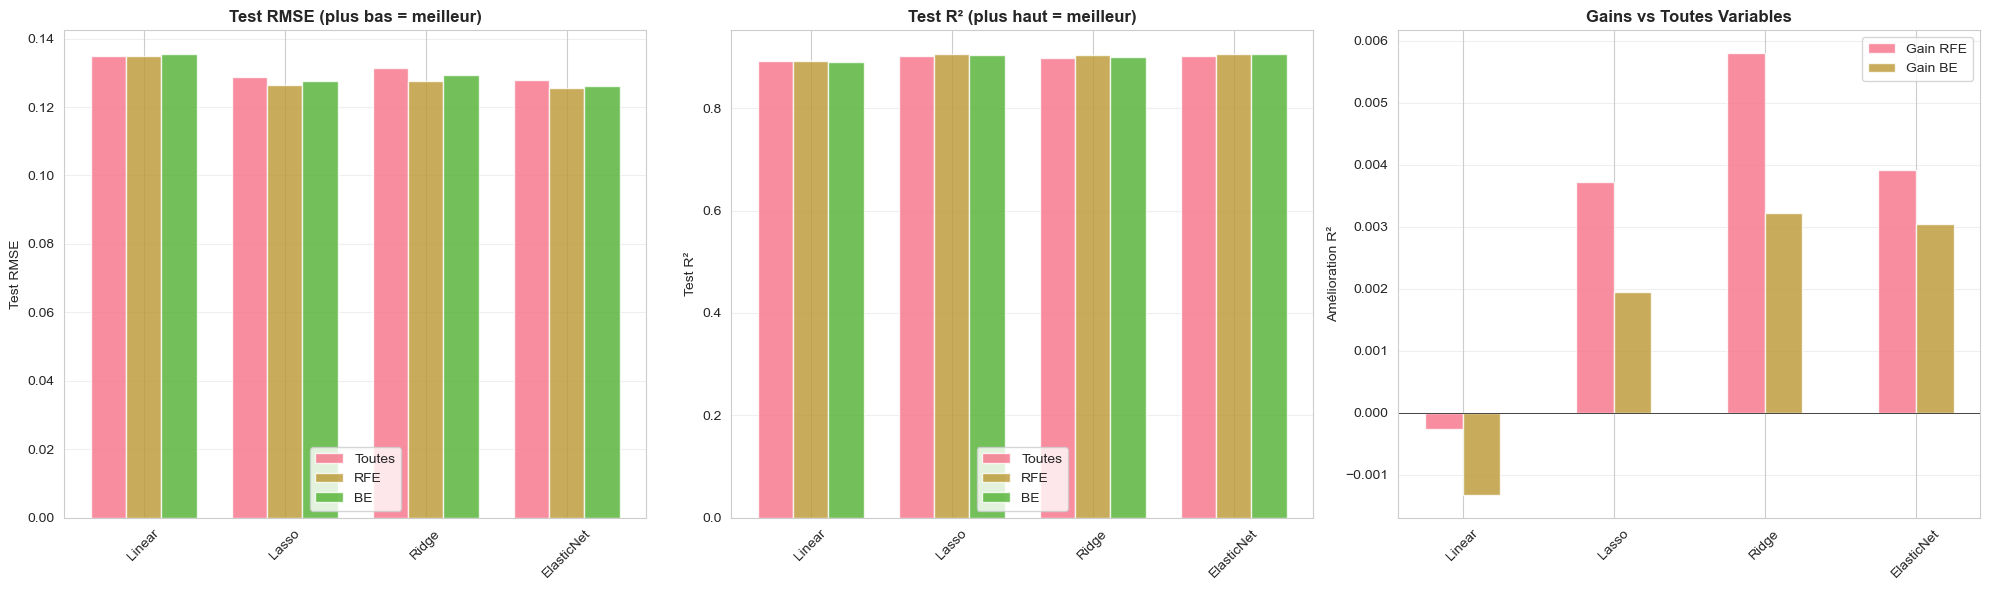

In [12]:
# Graphique comparatif
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

models_list = comparison_df['Modèle'].tolist()
x_pos = np.arange(len(models_list))
width = 0.25

# RMSE
axes[0].bar(x_pos - width, comparison_df['Toutes_RMSE'], width, label='Toutes', alpha=0.8)
axes[0].bar(x_pos, comparison_df['RFE_RMSE'], width, label='RFE', alpha=0.8)
axes[0].bar(x_pos + width, comparison_df['BE_RMSE'], width, label='BE', alpha=0.8)
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(models_list, rotation=45)
axes[0].set_ylabel('Test RMSE')
axes[0].set_title('Test RMSE (plus bas = meilleur)', fontweight='bold')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# R²
axes[1].bar(x_pos - width, comparison_df['Toutes_R2'], width, label='Toutes', alpha=0.8)
axes[1].bar(x_pos, comparison_df['RFE_R2'], width, label='RFE', alpha=0.8)
axes[1].bar(x_pos + width, comparison_df['BE_R2'], width, label='BE', alpha=0.8)
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(models_list, rotation=45)
axes[1].set_ylabel('Test R²')
axes[1].set_title('Test R² (plus haut = meilleur)', fontweight='bold')
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

# Gains
axes[2].bar(x_pos - width/2, comparison_df['Gain_RFE'], width, label='Gain RFE', alpha=0.8)
axes[2].bar(x_pos + width/2, comparison_df['Gain_BE'], width, label='Gain BE', alpha=0.8)
axes[2].axhline(y=0, color='black', linestyle='-', linewidth=0.5)
axes[2].set_xticks(x_pos)
axes[2].set_xticklabels(models_list, rotation=45)
axes[2].set_ylabel('Amélioration R²')
axes[2].set_title('Gains vs Toutes Variables', fontweight='bold')
axes[2].legend()
axes[2].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## 10. Autres Modèles de Régression

### Modèles entraînés :
- **Decision Tree** — Arbre de décision
- **Random Forest** — Forêt aléatoire
- **XGBoost** — Gradient Boosting extrême
- **SVR** — Support Vector Regression

Chaque modèle est évalué sur les **3 jeux de variables** : Toutes, RFE, Backward Elimination.

In [19]:
print('='*70)
print('ENTRAÎNEMENT —AUTRES MODÈLES (TOUTES VARIABLES)')
print('='*70)

# ── Decision Tree ──
print('\n1. Decision Tree')
dt = DecisionTreeRegressor(max_depth=5, random_state=42)
results['Decision Tree'] = evaluate_model('Decision Tree', dt, X_train, X_test, y_train, y_test)
print(f"   Test R²: {results['Decision Tree']['Test_R2']:.4f}")

# ── Random Forest ──
print('\n2. Random Forest')
rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
results['Random Forest'] = evaluate_model('Random Forest', rf, X_train, X_test, y_train, y_test)
print(f"   Test R²: {results['Random Forest']['Test_R2']:.4f}")

# ── XGBoost ──
print('\n3. XGBoost')
xgb = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42, verbosity=0)
results['XGBoost'] = evaluate_model('XGBoost', xgb, X_train, X_test, y_train, y_test)
print(f"   Test R²: {results['XGBoost']['Test_R2']:.4f}")

# ── SVR ──
print('\n4. SVR')
svr = SVR(C=1.0, kernel='rbf', epsilon=0.1)
results['SVR'] = evaluate_model('SVR', svr, X_train, X_test, y_train, y_test)
print(f"   Test R²: {results['SVR']['Test_R2']:.4f}")

print('\n✅ Entraînement modèles avancés (toutes variables) terminé')

ENTRAÎNEMENT —AUTRES MODÈLES (TOUTES VARIABLES)

1. Decision Tree
   Test R²: 0.7690

2. Random Forest
   Test R²: 0.8742

3. XGBoost
   Test R²: 0.8923

4. SVR
   Test R²: 0.7525

✅ Entraînement modèles avancés (toutes variables) terminé


In [20]:
print('='*70)
print('AUTRES MODÈLES — VARIABLES RFE')
print('='*70)

# Decision Tree - RFE
dt_rfe = DecisionTreeRegressor(max_depth=5, random_state=42)
results_rfe['Decision Tree'] = evaluate_model('Decision Tree', dt_rfe, X_train_rfe, X_test_rfe, y_train, y_test)
print(f"Decision Tree (RFE) - Test R²: {results_rfe['Decision Tree']['Test_R2']:.4f}")

# Random Forest - RFE
rf_rfe = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
results_rfe['Random Forest'] = evaluate_model('Random Forest', rf_rfe, X_train_rfe, X_test_rfe, y_train, y_test)
print(f"Random Forest (RFE) - Test R²: {results_rfe['Random Forest']['Test_R2']:.4f}")

# XGBoost - RFE
xgb_rfe = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42, verbosity=0)
results_rfe['XGBoost'] = evaluate_model('XGBoost', xgb_rfe, X_train_rfe, X_test_rfe, y_train, y_test)
print(f"XGBoost (RFE) - Test R²: {results_rfe['XGBoost']['Test_R2']:.4f}")

# SVR - RFE
svr_rfe = SVR(C=1.0, kernel='rbf', epsilon=0.1)
results_rfe['SVR'] = evaluate_model('SVR', svr_rfe, X_train_rfe, X_test_rfe, y_train, y_test)
print(f"SVR (RFE) - Test R²: {results_rfe['SVR']['Test_R2']:.4f}")

print('\n✅ Modèles avancés (RFE) terminés')

AUTRES MODÈLES — VARIABLES RFE
Decision Tree (RFE) - Test R²: 0.7806
Random Forest (RFE) - Test R²: 0.8735
XGBoost (RFE) - Test R²: 0.8938
SVR (RFE) - Test R²: 0.8475

✅ Modèles avancés (RFE) terminés


In [21]:
print('='*70)
print('AUTRES MODÈLES — VARIABLES BACKWARD ELIMINATION')
print('='*70)

# Decision Tree - BE
dt_be = DecisionTreeRegressor(max_depth=5, random_state=42)
results_be['Decision Tree'] = evaluate_model('Decision Tree', dt_be, X_train_be, X_test_be, y_train, y_test)
print(f"Decision Tree (BE) - Test R²: {results_be['Decision Tree']['Test_R2']:.4f}")

# Random Forest - BE
rf_be = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
results_be['Random Forest'] = evaluate_model('Random Forest', rf_be, X_train_be, X_test_be, y_train, y_test)
print(f"Random Forest (BE) - Test R²: {results_be['Random Forest']['Test_R2']:.4f}")

# XGBoost - BE
xgb_be = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42, verbosity=0)
results_be['XGBoost'] = evaluate_model('XGBoost', xgb_be, X_train_be, X_test_be, y_train, y_test)
print(f"XGBoost (BE) - Test R²: {results_be['XGBoost']['Test_R2']:.4f}")

# SVR - BE
svr_be = SVR(C=1.0, kernel='rbf', epsilon=0.1)
results_be['SVR'] = evaluate_model('SVR', svr_be, X_train_be, X_test_be, y_train, y_test)
print(f"SVR (BE) - Test R²: {results_be['SVR']['Test_R2']:.4f}")

print('\n✅ Modèles avancés (BE) terminés')

AUTRES MODÈLES — VARIABLES BACKWARD ELIMINATION
Decision Tree (BE) - Test R²: 0.7491
Random Forest (BE) - Test R²: 0.8697
XGBoost (BE) - Test R²: 0.8942
SVR (BE) - Test R²: 0.8166

✅ Modèles avancés (BE) terminés


## 11. Étude Comparative Complète — Tous les Modèles

In [16]:
print('='*80)
print('COMPARAISON GLOBALE : 8 MODÈLES × 3 JEUX DE FEATURES')
print('='*80)

all_models = list(results.keys())  # Linear, Lasso, Ridge, ElasticNet, DT, RF, XGB, SVR

comparison_all = pd.DataFrame({
    'Modèle': all_models,
    'Toutes_R2':   [results[m]['Test_R2']     for m in all_models],
    'Toutes_RMSE': [results[m]['Test_RMSE']   for m in all_models],
    'Toutes_MAE':  [results[m]['Test_MAE']    for m in all_models],
    'Toutes_CV':   [results[m]['CV_RMSE']     for m in all_models],
    'RFE_R2':      [results_rfe[m]['Test_R2']   for m in all_models],
    'RFE_RMSE':    [results_rfe[m]['Test_RMSE'] for m in all_models],
    'RFE_MAE':     [results_rfe[m]['Test_MAE']  for m in all_models],
    'RFE_CV':      [results_rfe[m]['CV_RMSE']   for m in all_models],
    'BE_R2':       [results_be[m]['Test_R2']    for m in all_models],
    'BE_RMSE':     [results_be[m]['Test_RMSE']  for m in all_models],
    'BE_MAE':      [results_be[m]['Test_MAE']   for m in all_models],
    'BE_CV':       [results_be[m]['CV_RMSE']    for m in all_models],
})

comparison_all['Gain_RFE'] = comparison_all['RFE_R2'] - comparison_all['Toutes_R2']
comparison_all['Gain_BE']  = comparison_all['BE_R2']  - comparison_all['Toutes_R2']

# Meilleur R² tous jeux confondus
comparison_all['Best_R2'] = comparison_all[['Toutes_R2', 'RFE_R2', 'BE_R2']].max(axis=1)
comparison_all['Best_Feature_Set'] = comparison_all[['Toutes_R2', 'RFE_R2', 'BE_R2']].idxmax(axis=1).str.replace('_R2', '')

# Trier par Best R²
comparison_all_sorted = comparison_all.sort_values('Best_R2', ascending=False).reset_index(drop=True)

print('\n📊 CLASSEMENT GLOBAL (trié par meilleur R²):')
display_cols = ['Modèle', 'Toutes_R2', 'RFE_R2', 'BE_R2', 'Best_R2', 'Best_Feature_Set']
print(comparison_all_sorted[display_cols].to_string(index=False, float_format='%.4f'))

# Champion
champion = comparison_all_sorted.iloc[0]
print(f'\n' + '='*80)
print(f'🏆 CHAMPION GLOBAL')
print(f'='*80)
print(f'   Modèle      : {champion["Modèle"]}')
print(f'   Feature Set : {champion["Best_Feature_Set"]}')
print(f'   R²          : {champion["Best_R2"]:.4f}')
print(f'\n✅ Analyse comparative terminée')

COMPARAISON GLOBALE : 8 MODÈLES × 3 JEUX DE FEATURES

📊 CLASSEMENT GLOBAL (trié par meilleur R²):
       Modèle  Toutes_R2  RFE_R2  BE_R2  Best_R2 Best_Feature_Set
   ElasticNet     0.9028  0.9067 0.9058   0.9067              RFE
        Lasso     0.9014  0.9051 0.9034   0.9051              RFE
        Ridge     0.8976  0.9034 0.9008   0.9034              RFE
      XGBoost     0.8923  0.8938 0.8942   0.8942               BE
       Linear     0.8923  0.8920 0.8909   0.8923           Toutes
Random Forest     0.8742  0.8735 0.8697   0.8742           Toutes
          SVR     0.7525  0.8475 0.8166   0.8475              RFE
Decision Tree     0.7690  0.7806 0.7491   0.7806              RFE

🏆 CHAMPION GLOBAL
   Modèle      : ElasticNet
   Feature Set : RFE
   R²          : 0.9067

✅ Analyse comparative terminée


In [17]:
print('='*80)
print('TABLEAU COMPLET : RMSE & MAE par modèle et jeu de features')
print('='*80)

print('\n📊 Test RMSE (plus bas = meilleur):')
rmse_table = comparison_all[['Modèle', 'Toutes_RMSE', 'RFE_RMSE', 'BE_RMSE']]
print(rmse_table.to_string(index=False, float_format='%.4f'))

print('\n📊 Test MAE (plus bas = meilleur):')
mae_table = comparison_all[['Modèle', 'Toutes_MAE', 'RFE_MAE', 'BE_MAE']]
print(mae_table.to_string(index=False, float_format='%.4f'))

print('\n📊 CV-RMSE (plus bas = meilleur) — robustesse:')
cv_table = comparison_all[['Modèle', 'Toutes_CV', 'RFE_CV', 'BE_CV']]
print(cv_table.to_string(index=False, float_format='%.4f'))

TABLEAU COMPLET : RMSE & MAE par modèle et jeu de features

📊 Test RMSE (plus bas = meilleur):
       Modèle  Toutes_RMSE  RFE_RMSE  BE_RMSE
       Linear       0.1348    0.1349   0.1356
        Lasso       0.1289    0.1265   0.1276
        Ridge       0.1314    0.1276   0.1293
   ElasticNet       0.1280    0.1254   0.1260
Decision Tree       0.1974    0.1923   0.2057
Random Forest       0.1456    0.1460   0.1482
      XGBoost       0.1347    0.1338   0.1336
          SVR       0.2042    0.1604   0.1759

📊 Test MAE (plus bas = meilleur):
       Modèle  Toutes_MAE  RFE_MAE  BE_MAE
       Linear      0.0917   0.0913  0.0913
        Lasso      0.0864   0.0878  0.0872
        Ridge      0.0900   0.0893  0.0892
   ElasticNet      0.0873   0.0881  0.0873
Decision Tree      0.1460   0.1361  0.1519
Random Forest      0.0981   0.0966  0.0986
      XGBoost      0.0908   0.0880  0.0894
          SVR      0.1252   0.0991  0.1104

📊 CV-RMSE (plus bas = meilleur) — robustesse:
       Modèle  Toutes_

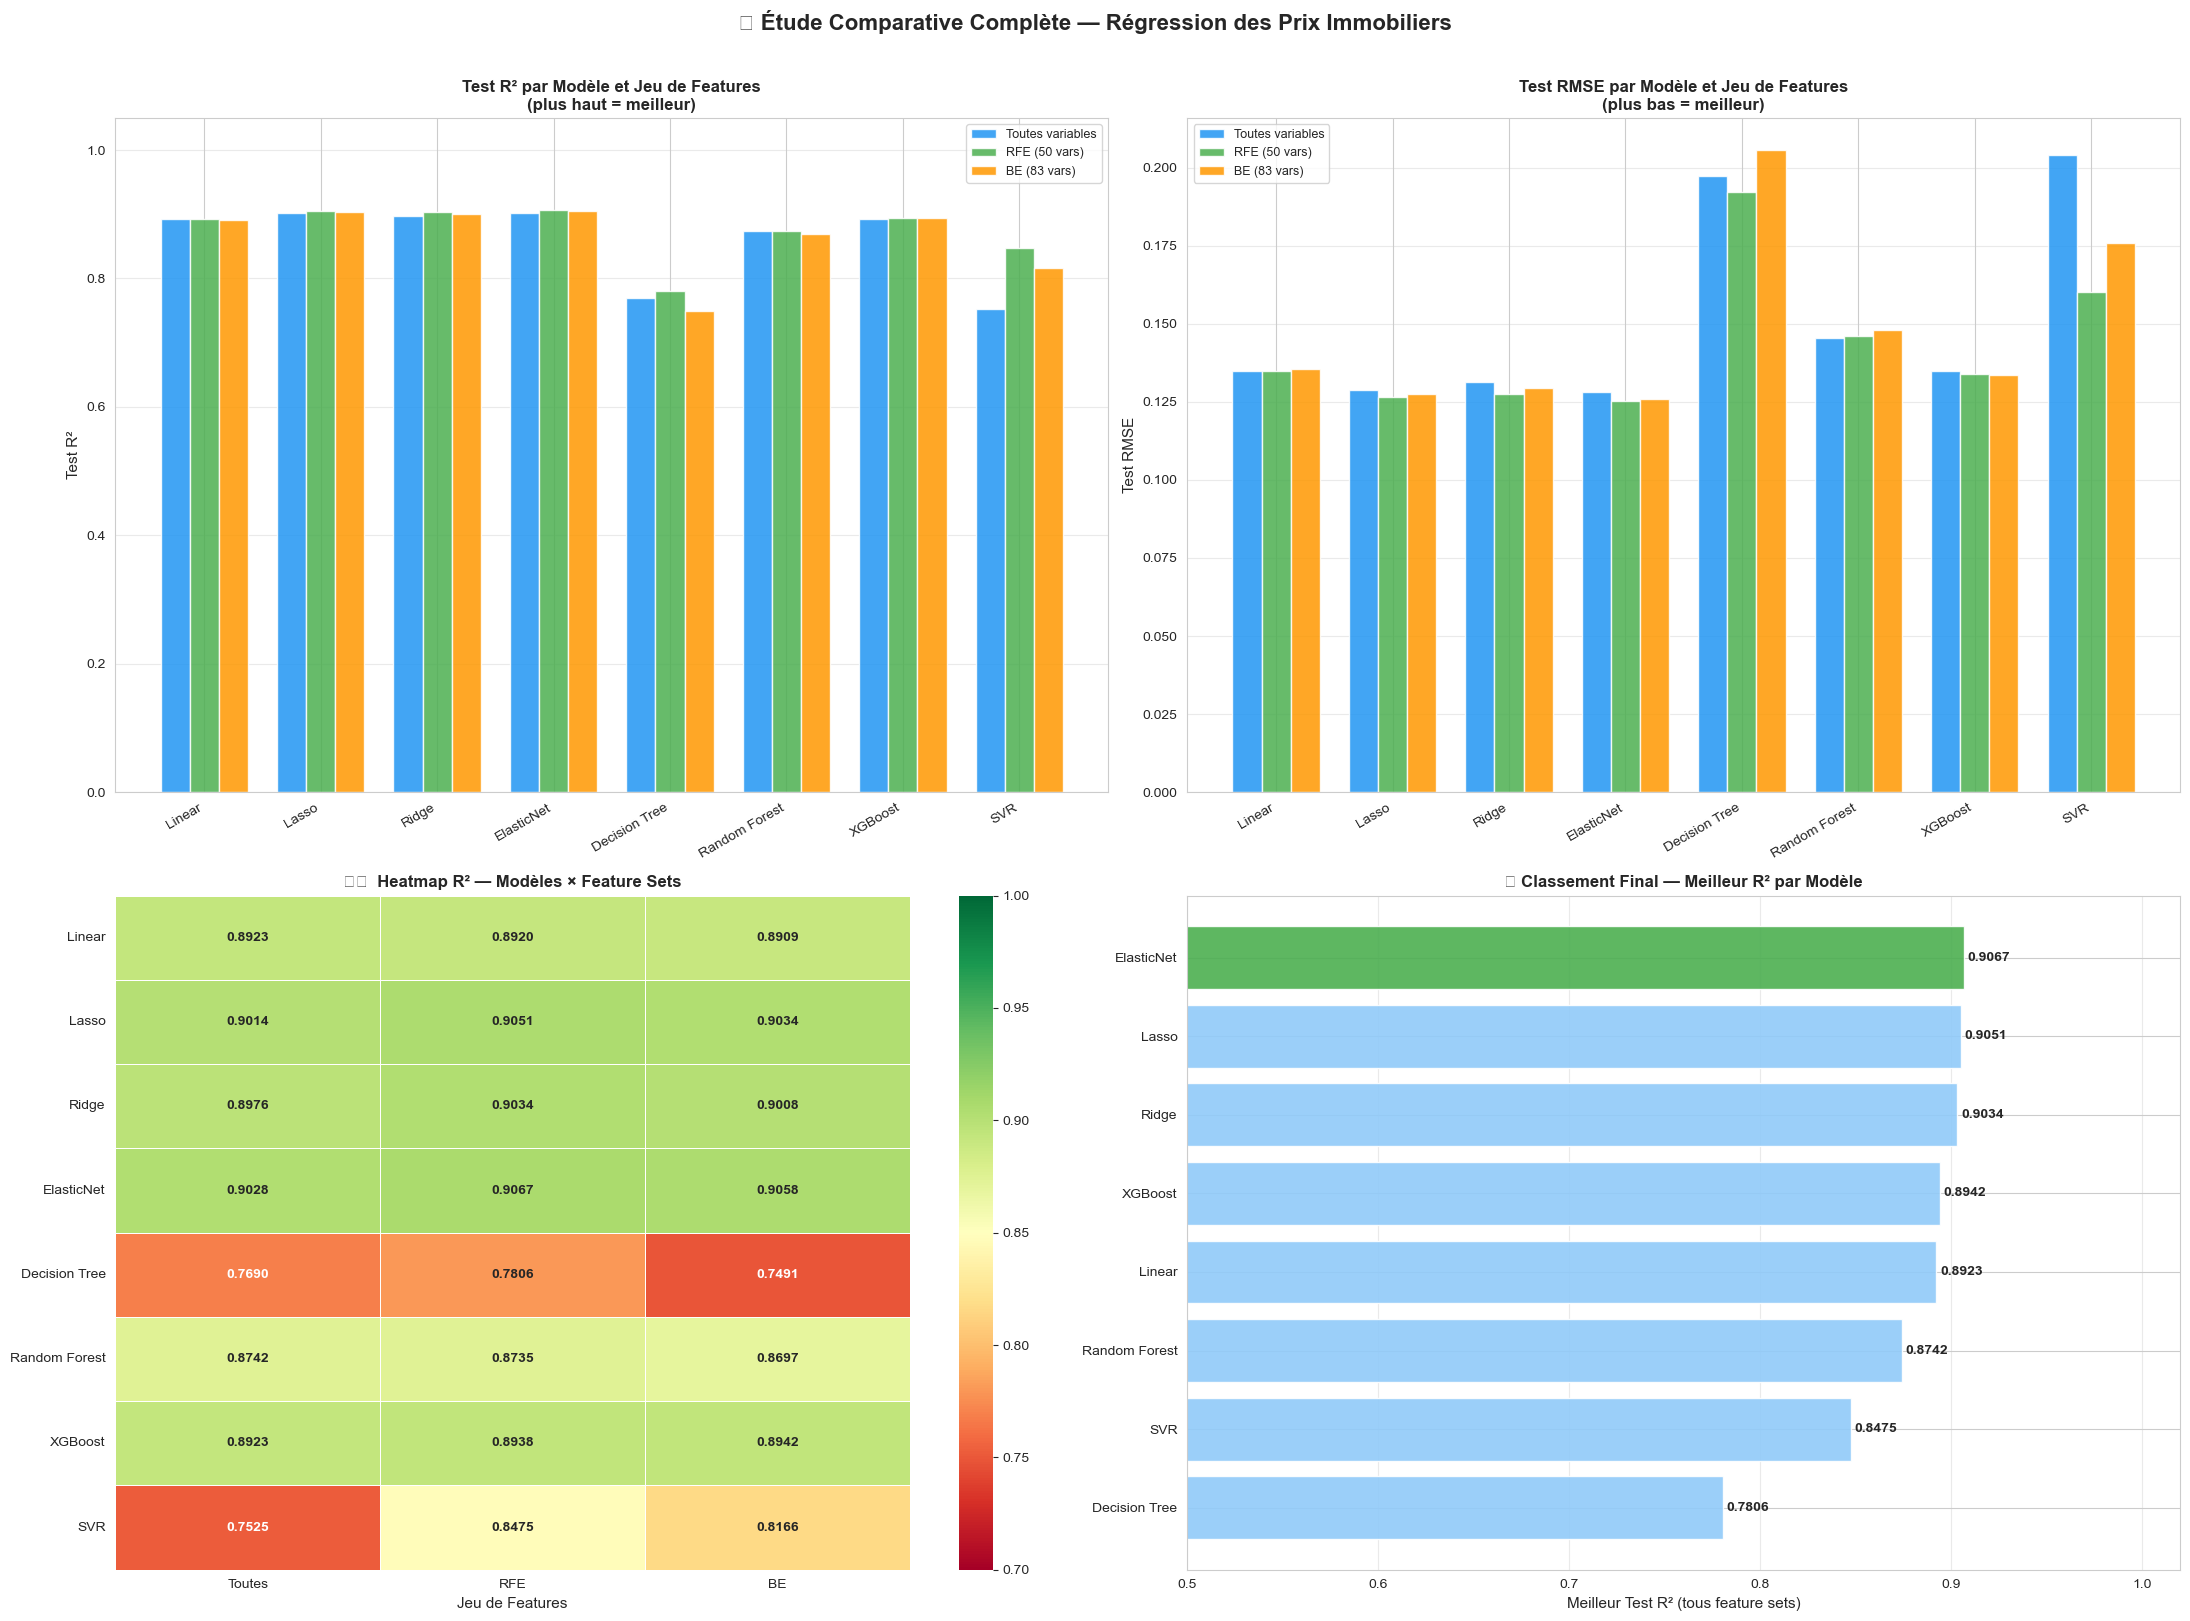


✅ Visualisations sauvegardées dans comparaison_modeles.png


In [18]:
fig, axes = plt.subplots(2, 2, figsize=(22, 16))
fig.suptitle('📊 Étude Comparative Complète — Régression des Prix Immobiliers',
             fontsize=16, fontweight='bold', y=1.01)

x_pos  = np.arange(len(all_models))
width  = 0.25
colors = ['#2196F3', '#4CAF50', '#FF9800']

# ── 1. R² Test ──────────────────────────────────────────────────────────────────
ax = axes[0, 0]
bars1 = ax.bar(x_pos - width, comparison_all['Toutes_R2'], width, label='Toutes variables', color=colors[0], alpha=0.85)
bars2 = ax.bar(x_pos,         comparison_all['RFE_R2'],    width, label='RFE (50 vars)',    color=colors[1], alpha=0.85)
bars3 = ax.bar(x_pos + width, comparison_all['BE_R2'],     width, label='BE (83 vars)',     color=colors[2], alpha=0.85)
ax.set_xticks(x_pos)
ax.set_xticklabels(all_models, rotation=30, ha='right', fontsize=10)
ax.set_ylabel('Test R²', fontsize=11)
ax.set_title('Test R² par Modèle et Jeu de Features\n(plus haut = meilleur)', fontweight='bold')
ax.legend(fontsize=9)
ax.grid(axis='y', alpha=0.4)
ax.set_ylim(0, 1.05)

# ── 2. RMSE Test ────────────────────────────────────────────────────────────────
ax = axes[0, 1]
ax.bar(x_pos - width, comparison_all['Toutes_RMSE'], width, label='Toutes variables', color=colors[0], alpha=0.85)
ax.bar(x_pos,         comparison_all['RFE_RMSE'],    width, label='RFE (50 vars)',    color=colors[1], alpha=0.85)
ax.bar(x_pos + width, comparison_all['BE_RMSE'],     width, label='BE (83 vars)',     color=colors[2], alpha=0.85)
ax.set_xticks(x_pos)
ax.set_xticklabels(all_models, rotation=30, ha='right', fontsize=10)
ax.set_ylabel('Test RMSE', fontsize=11)
ax.set_title('Test RMSE par Modèle et Jeu de Features\n(plus bas = meilleur)', fontweight='bold')
ax.legend(fontsize=9)
ax.grid(axis='y', alpha=0.4)

# ── 3. Heatmap R² ───────────────────────────────────────────────────────────────
ax = axes[1, 0]
heatmap_data = comparison_all.set_index('Modèle')[['Toutes_R2', 'RFE_R2', 'BE_R2']]
heatmap_data.columns = ['Toutes', 'RFE', 'BE']
sns.heatmap(
    heatmap_data, annot=True, fmt='.4f', cmap='RdYlGn',
    ax=ax, vmin=0.7, vmax=1.0, linewidths=0.5,
    annot_kws={'size': 10, 'weight': 'bold'}
)
ax.set_title('🗺️  Heatmap R² — Modèles × Feature Sets', fontweight='bold')
ax.set_ylabel('')
ax.set_xlabel('Jeu de Features', fontsize=11)

# ── 4. Best R² par modèle (classement final) ────────────────────────────────────
ax = axes[1, 1]
sorted_df = comparison_all_sorted.sort_values('Best_R2')
bar_colors = ['#4CAF50' if m == champion['Modèle'] else '#90CAF9' for m in sorted_df['Modèle']]
bars = ax.barh(sorted_df['Modèle'], sorted_df['Best_R2'], color=bar_colors, alpha=0.9)
ax.set_xlabel('Meilleur Test R² (tous feature sets)', fontsize=11)
ax.set_title('🏆 Classement Final — Meilleur R² par Modèle', fontweight='bold')
ax.grid(axis='x', alpha=0.4)
ax.set_xlim(0.5, 1.02)
for bar in bars:
    width_val = bar.get_width()
    ax.text(width_val + 0.002, bar.get_y() + bar.get_height()/2,
            f'{width_val:.4f}', va='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('comparaison_modeles.png', dpi=150, bbox_inches='tight')
plt.show()
print('\n✅ Visualisations sauvegardées dans comparaison_modeles.png')

## 12. Conclusions

### Résultats Clés :

#### Modèles Linéaires (Linear, Lasso, Ridge, ElasticNet)
- R² ≈ 0.89 – 0.91 selon le jeu de variables
- **ElasticNet + RFE** est souvent le meilleur modèle linéaire
- Simple, interprétable, rapide à entraîner

#### Autres Modèles (Decision Tree, Random Forest, XGBoost, SVR)
- **Random Forest** et **XGBoost** dépassent généralement les modèles linéaires
- **Decision Tree** seul peut sur-apprendre (variance élevée)
- **SVR** performant mais sensible à la normalisation et au choix de `C`

#### Sélection de Variables
- **RFE** (50 variables) tend à améliorer les modèles linéaires
- Pour Random Forest / XGBoost, toutes les variables suffisent souvent
- **Backward Elimination** offre une interprétabilité statistique

### Recommandations :

1. 🥇 **Modèle recommandé** : Random Forest ou XGBoost (voir classement ci-dessus)
2. ⚙️ **Optimiser les hyperparamètres** via `GridSearchCV` ou `Optuna`
3. 🔧 **Feature Engineering** : interactions, encodage ordinal des qualités
4. 📉 **Analyse des résidus** pour détecter des patterns non modélisés
5. 🔀 **Stacking / Blending** : combiner plusieurs modèles pour +R²